<a href="https://colab.research.google.com/github/shanaam/teamA-grebes-NMA2020/blob/master/SM/200723_sm_nma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#@title Data retrieval amd loading
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [84]:
# import packages
from scipy.io import loadmat
import os, fnmatch
from google.colab import drive
from google.colab import files
import math
import os, requests
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.rcParams['figure.figsize'] = [20, 4]
plt.rcParams['font.size'] =15
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.autolayout'] = True

%config InlineBackend.figure_format = 'retina'

In [26]:
# mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
print(dat['sresp'].shape)
print(len(dat['stat']))
print((dat['stat'][19].dtype))
print(dat['stat'][19]['med'])

(11983, 7018)
11983
[('ipix', 'O'), ('ypix', 'O'), ('xpix', 'O'), ('lam', 'O'), ('lambda', 'O'), ('npix', 'O'), ('med', 'O'), ('neuropilCoefficient', 'O'), ('baseline', 'O'), ('footprint', 'O'), ('mrs', 'O'), ('mrs0', 'O'), ('cmpct', 'O'), ('aspect_ratio', 'O'), ('ellipse', 'O'), ('mimgProj', 'O'), ('mimgProjAbs', 'O'), ('isoverlap', 'O'), ('radius', 'O'), ('ipix_neuropil', 'O'), ('dFstat', 'O'), ('skew', 'O'), ('std', 'O'), ('maxMinusMed', 'O'), ('top5pcMinusMed', 'O'), ('blockstarts', 'O'), ('iplane', 'O'), ('iscell', 'O'), ('noiseLevel', 'O')]
[array([[191.5,  23. ]])]


In [28]:
num_cells,num_times = dat['sresp'].shape
run = np.squeeze(dat['run'])
sresp = dat['sresp']

[Text(0, 0.5, 'Ca2+ Activity'), Text(0.5, 0, 'Time')]

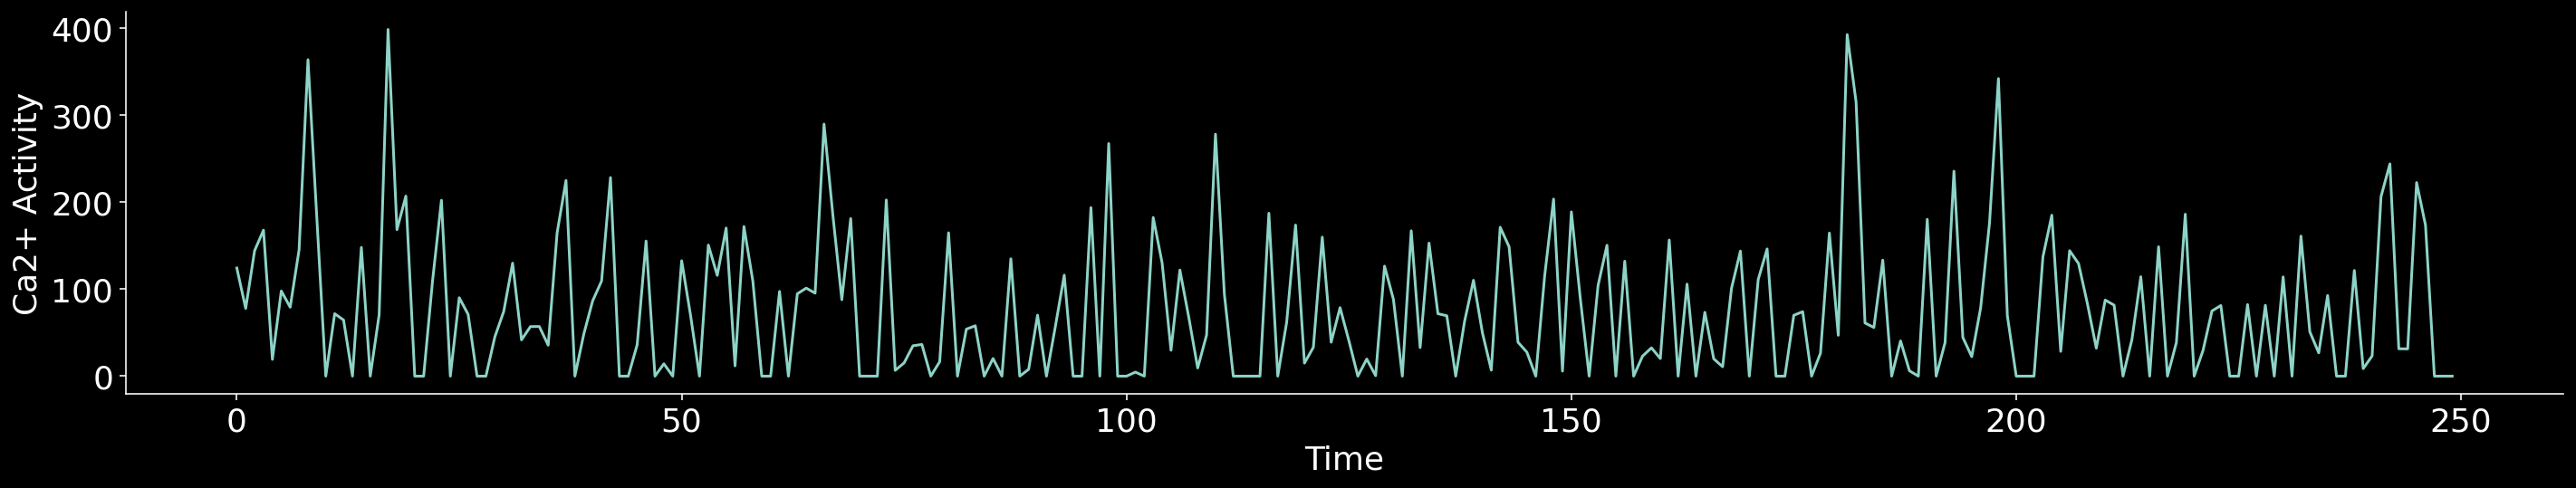

In [29]:
neuron_idx = 134
stop_len = 250
plt.plot(sresp[neuron_idx,:stop_len])
ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Ca2+ Activity",
)

[Text(0, 0.5, 'Running Speed [a.u.]'), Text(0.5, 0, 'Time')]

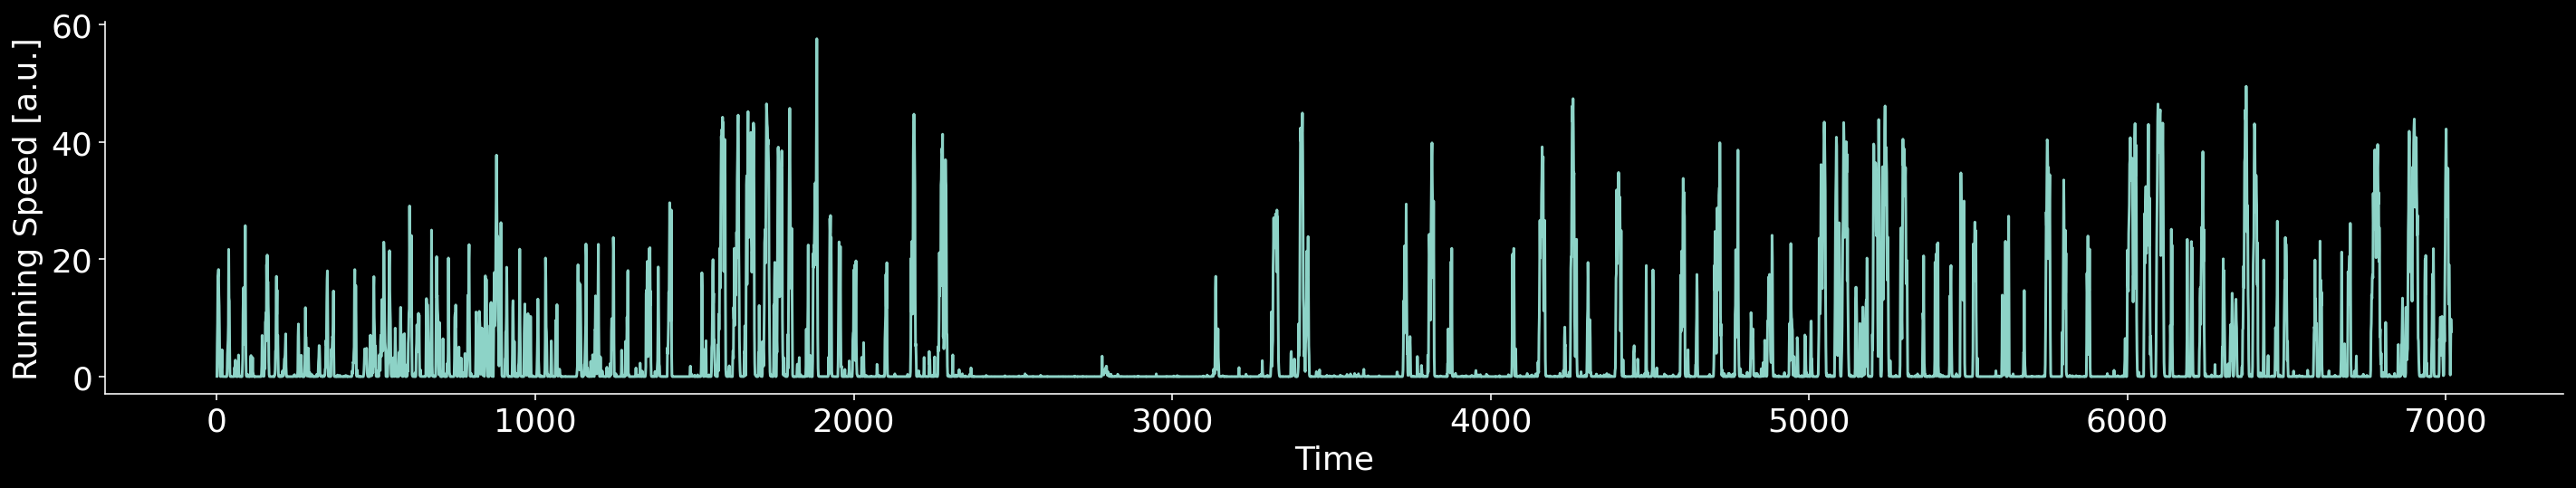

In [30]:
plt.plot(run[:])
ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Running Speed [a.u.]",
)

## serialize running speed

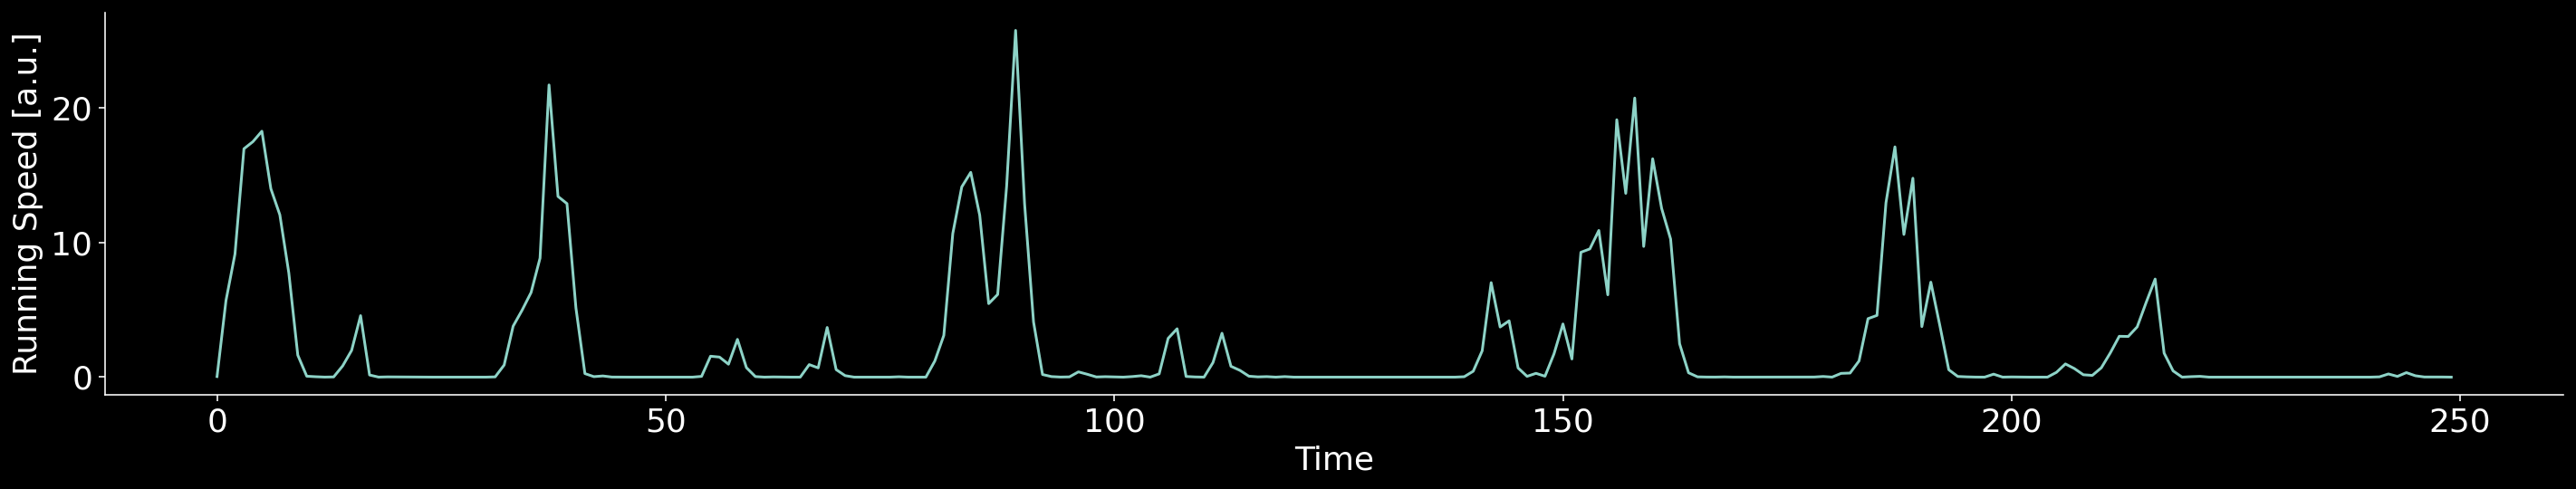

In [31]:
plt.plot(run[:stop_len])

t = np.arange(stop_len)

ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Running Speed [a.u.]",
)
plt.show()

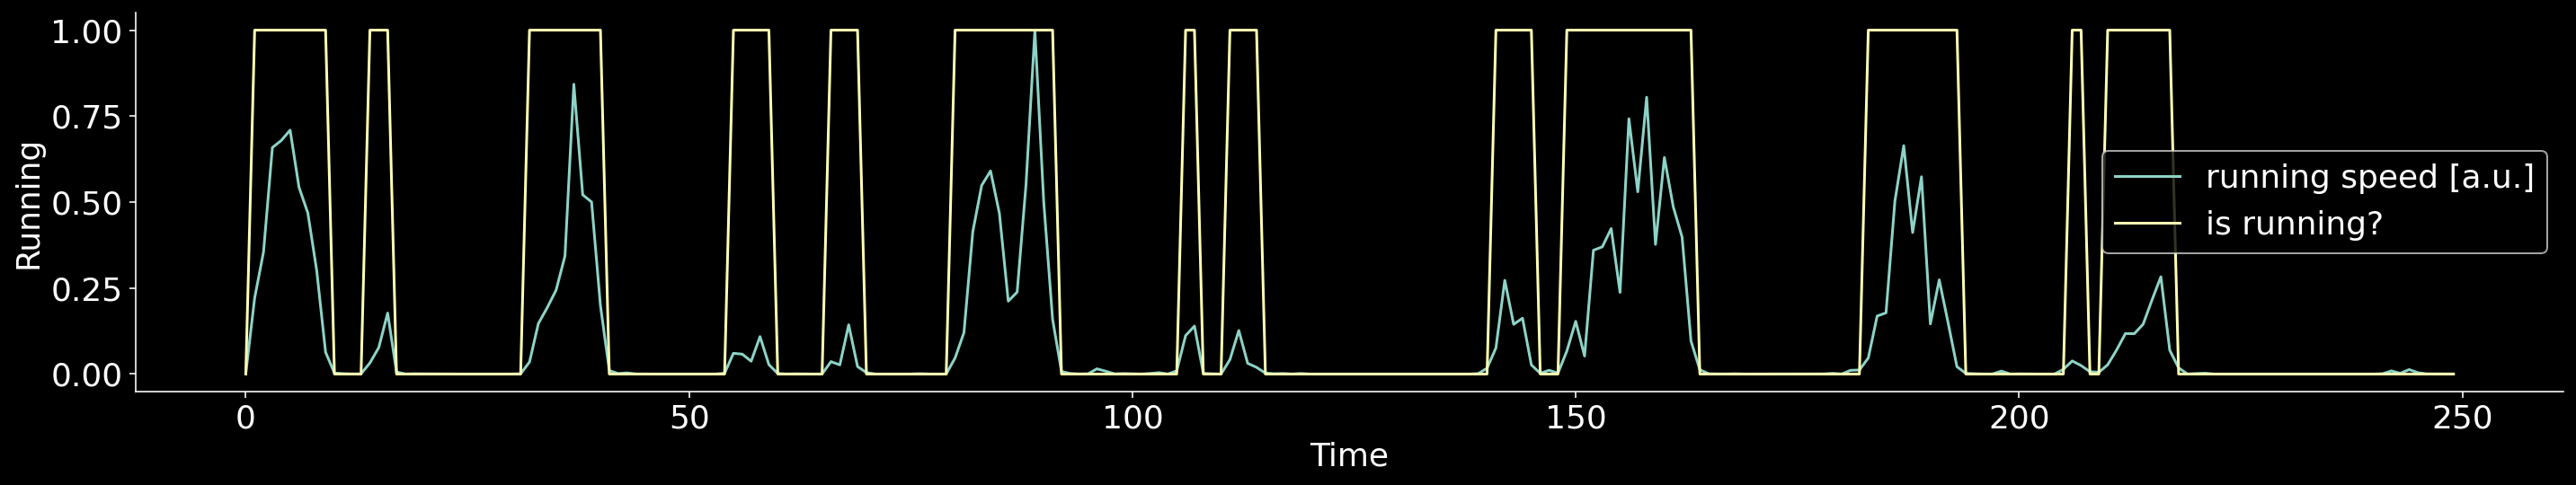

In [32]:
run_thres = 0.5 #cut-off threhold for running speed to be considered running [a.u.]

#function to detm if running
def is_running(x):
  if x >= run_thres:
    return 1
  else:
    return 0

# map the above funtion to our run
is_run = np.array([is_running(xi) for xi in run])

#plot
plt.plot(run[:stop_len]/ max(run[:stop_len]), label = "running speed [a.u.]")
plt.plot(is_run[:stop_len], label = "is running?")
plt.xlabel("Time")
plt.ylabel("Running")
plt.legend()
plt.show()

## index starting points

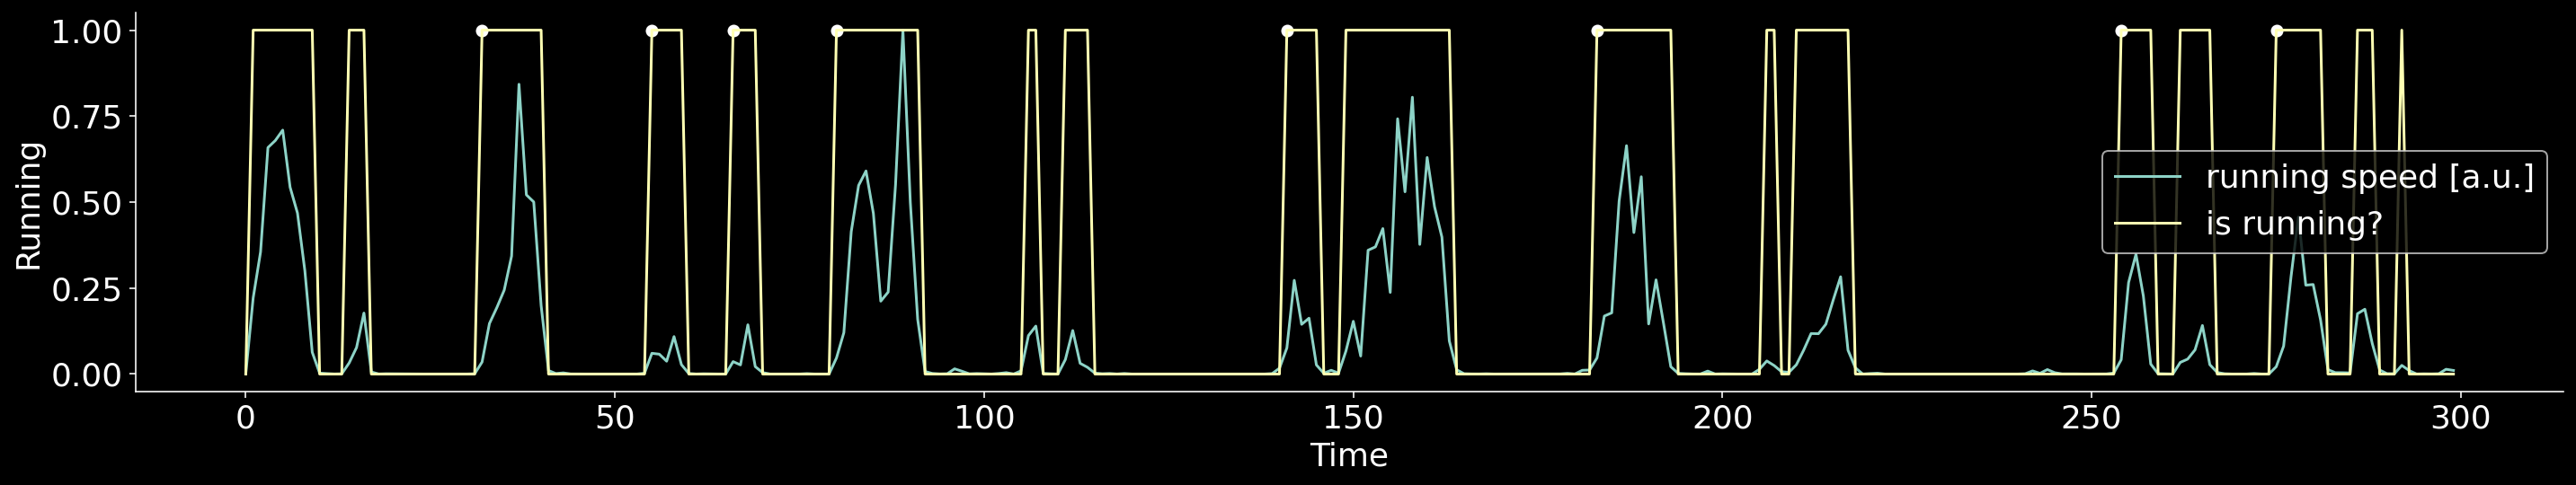

Total # of run starts:  116


In [101]:
stop_len = 300
searchval = [0,0,0,0,1,1,1,1]

idx = [np.s_[i:len(is_run) - len(searchval) +1+i] for i in range(len(searchval))]

x = [is_run[idx[i]] == searchval[i] for i in range(len(searchval))]

x = np.all(x, axis=0)

run_starts = np.where(x)[0] + 4

#plot
plt.plot(run[:stop_len]/ max(run[:stop_len]), label = "running speed [a.u.]")
plt.plot(is_run[:stop_len], label = "is running?")
plt.scatter(run_starts[run_starts < stop_len], np.repeat(1, len(run_starts[run_starts < stop_len])), color = "white")
plt.xlabel("Time")
plt.ylabel("Running")
plt.legend()
plt.show()

print("Total # of run starts: ", len(run_starts))

## splice (TODO: add confints?)

In [68]:
# given a neuron index, and an array of run_starts, output a mean_activity array
def confint_95(a):
  return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

def event_dep_activity(neuron_idx, activity_starts, pad_time_bins):
  neuron = sresp[neuron_idx,:]
  neur_grid = []

  for start in activity_starts:
    x = neuron[start-pad_time_bins:start+1+pad_time_bins]
    x = x-np.mean(x)
    neur_grid.append(x)

  neur_grid = np.stack(neur_grid, axis=0)

  mean_activity = np.mean(neur_grid, axis=0)
  
  confint = np.array([confint_95(row) for row in neur_grid.T])

  return mean_activity, confint


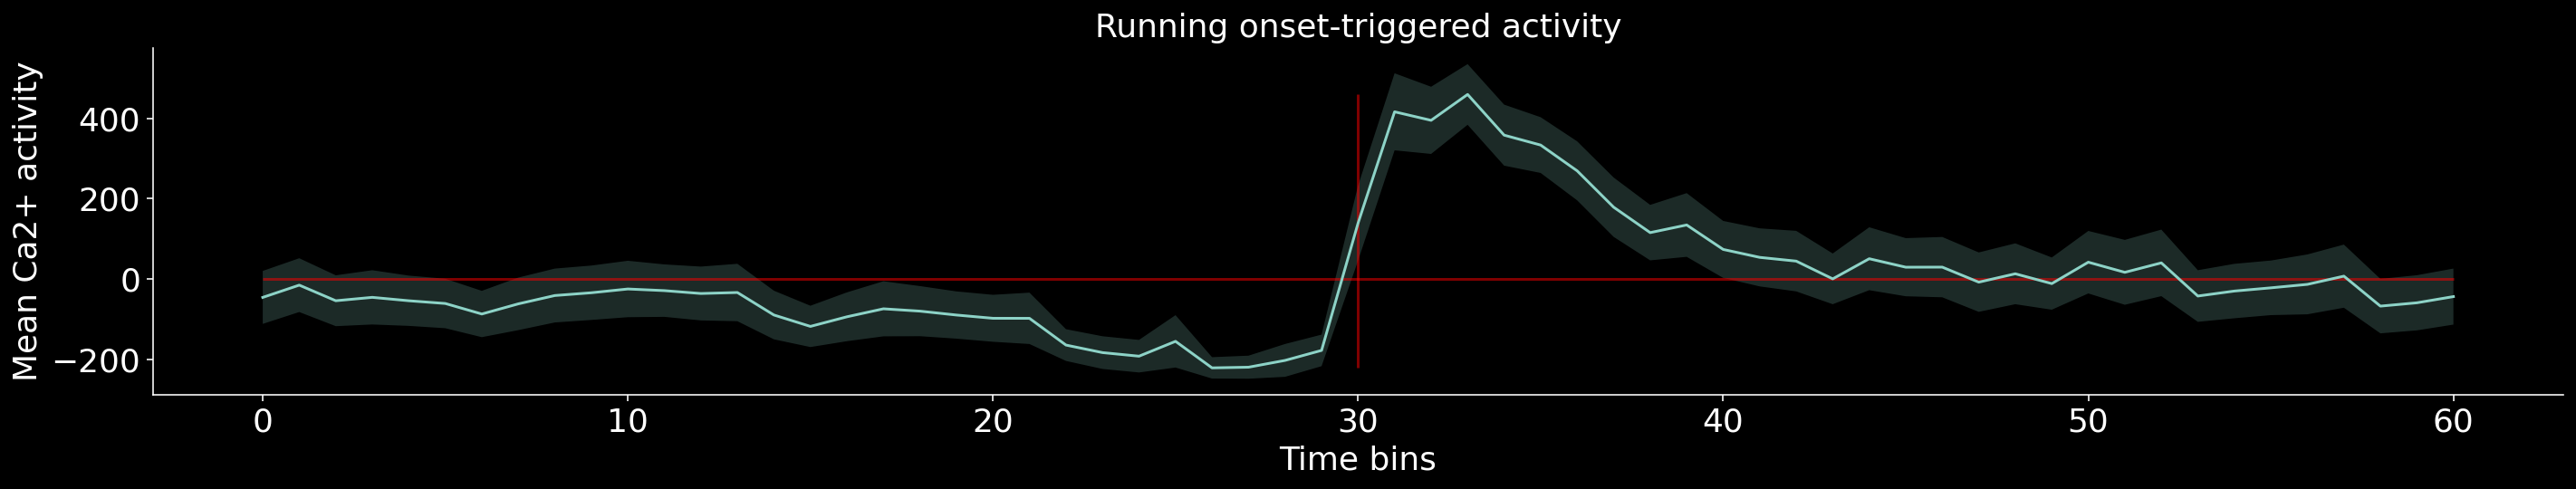

In [85]:
# plot mean activity
# CONFINT??? st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

pad_time_bins = 30

test_mean, test_confint = event_dep_activity(1373, run_starts, pad_time_bins=pad_time_bins)

plt.plot(test_mean)
plt.fill_between(np.arange(0, (pad_time_bins * 2) + 1), 
                 test_confint[: , 0], test_confint[: , 1],
                 alpha = 0.2, linewidth = 0.)
plt.title("Running onset-triggered activity")
plt.xlabel("Time bins")
plt.ylabel("Mean Ca2+ activity")
plt.hlines(0, 0, pad_time_bins * 2, color = "red", alpha = 0.5)
plt.vlines(pad_time_bins, min(test_mean), max(test_mean), color = "red", alpha = 0.5)
plt.show()



In [70]:
#load in Di's

(5, 2)


array([-268.08725489, -249.77154122,  100.55843282,  379.75446611,
        357.61011126])

In [37]:
#settings
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

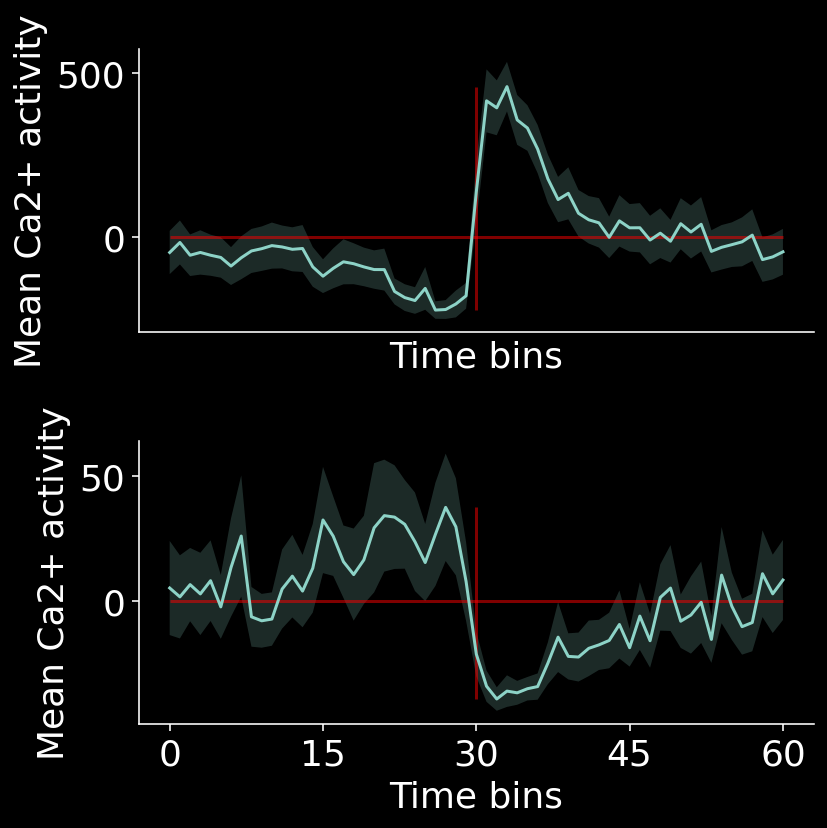

In [99]:
# plot the example neurons for poster
fig, axs = plt.subplots(2,1, figsize=(6,6), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.1)

test_mean, test_confint = event_dep_activity(1373, run_starts, pad_time_bins=pad_time_bins)

axs[0].plot(test_mean)
axs[0].fill_between(np.arange(0, (pad_time_bins * 2) + 1), 
                 test_confint[: , 0], test_confint[: , 1],
                 alpha = 0.2, linewidth = 0.)
axs[0].set_xlabel("Time bins")
axs[0].set_ylabel("Mean Ca2+ activity")
axs[0].get_xaxis().set_ticks([])
axs[0].hlines(0, 0, pad_time_bins * 2, color = "red", alpha = 0.5)
axs[0].vlines(pad_time_bins, min(test_mean), max(test_mean), color = "red", alpha = 0.5)

test_mean, test_confint = event_dep_activity(2963, run_starts, pad_time_bins=pad_time_bins)

axs[1].plot(test_mean)
axs[1].fill_between(np.arange(0, (pad_time_bins * 2) + 1), 
                 test_confint[: , 0], test_confint[: , 1],
                 alpha = 0.2, linewidth = 0.)
axs[1].set_xlabel("Time bins")
axs[1].set_ylabel("Mean Ca2+ activity")
axs[1].get_xaxis().set_ticks([0, 15, 30, 45, 60])
axs[1].hlines(0, 0, pad_time_bins * 2, color = "red", alpha = 0.5)
axs[1].vlines(pad_time_bins, min(test_mean), max(test_mean), color = "red", alpha = 0.5)

fig.savefig("event_triggered.png",dpi=600,transparent=True,bbox_inches="tight")
files.download("event_triggered.png")